# Create Features from Stock Dataset

The stock data set consists of features. A single feature vector is a list consisting of

* time series of stock prices
* chart indicators
* window length (length of time series)
* return as a ratio
* horizon is the number of days after the window's last day

The latter two are parameters defined by the user in this notebook.

The return is the ratio when we buy the stock at the window's last day and sell it `horizon` days afterwards.

**User task:** Define variables and parameters. 

### **File variables**

In [1]:
input_csv_file = './stockdata.csv'
train_data_file = './train_set.parquet'
eval_data_file = './eval_set.parquet'

### **Parameters**

There are two parameter sections

1. Feature sampling
1. Split partitions for training and evalation (testing). The latter is the holdout dataset.

#### **Sampling**

For $m$ different window lengths and $m$ different return horizons, we select $k$ windows from the stock data. For each window, we compute the stock feature vector. The final feature set contains  $m * m * k$ feature vectors. 

In [2]:
# parameters
m = 20
# m different window lengths
w = [i for i in range(5,5+m)]
# m different return horizons
h = [i for i in range(5,5+m)]
# number of date samples
k = 20

#### **Split partitions**

Split train and test (eval) partition. We are using the term _eval_ here, to indicate its use in the `ludwig evaluation ...` command.

* $\kappa \in [0,1]$ is the relative size of the training partition starting with the oldest date    
* $1-\kappa$ is the eval partition    
* $\kappa_{random}$ lower part of the training partition, where random window sampling is applied.
$1-\kappa_{random}$ consists of all partitions (train, eval) where consecutive window sampling is applied.

The following relations are valid:     
* $\kappa = \kappa_{random} + (\kappa-\kappa_{random})$, where $\kappa-\kappa_{random}$ is the part within the training partition where consecutive sampling is applied
* $1 = \kappa + (1-\kappa)$

If $\kappa_{random} = -1$, then all partions will use random window sampling.

**Note:** The number $k$ of date samples is distributed accordingly across the partitions.

In [3]:
# split parameters
kappa = 0.6 # 60% training, 40% eval
kappa_random = kappa - 0.1 # lower random partition within train
kappa_random = -1

In [4]:
assert kappa >= 0
assert kappa <= 1

if kappa_random != -1:
    assert kappa_random >=0
    assert kappa_random <=1
    kappa_random <= kappa
else:
    assert kappa_random == -1

assert k,m > 0

#### **Classification Targets**

YASMaPE approaches a regression and a classification problem. `create_feature` computes the revenue and stores it in the `return` variable. Latter is used as regression target. Addtionally, it also computes the classification target variable from the `return` value. It implements the following rule.
```
if return > x:
  retgtx = True
else:
  retgtx = False
```
The parameter specifies a list of x values for the rule above.

In [5]:
classification_targets = [t for t in range(1,100, 2)]

#### Install and import

In [6]:
# Install a pip module in the current Jupyter kernel
import sys

try:
    from stockstats import StockDataFrame as sdf
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install stockstats

try:
    import pyarrow as pa
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install pyarrow

In [7]:
# imports
import pandas as pd
import numpy as np
from stockstats import StockDataFrame as sdf
import random
import math

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style 

## Load csv data

We assume a csv file containing stock prices with features from `colnames`.

In [8]:
# Path to data is in parameter 'input_csv_file'

# import data
colnames = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
data = pd.read_csv(input_csv_file, delimiter=',', header=0, names=colnames, decimal='.')
stock  = sdf.retype(data)
# sort by date ascending 
stock.sort_index(ascending=True, inplace=True)

In [9]:
stock.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2021-09-06,10.610,10.834,10.566,10.762,10.535241,6424293
2021-09-07,10.750,10.874,10.718,10.868,10.639008,6205259
2021-09-08,10.762,10.922,10.670,10.812,10.584188,7894023
2021-09-09,10.710,10.904,10.560,10.844,10.615513,6868521
2021-09-10,10.864,11.020,10.774,10.812,10.584188,6873800


## Data Visualization

Let's quickly review the data.

<AxesSubplot:xlabel='label', ylabel='price'>

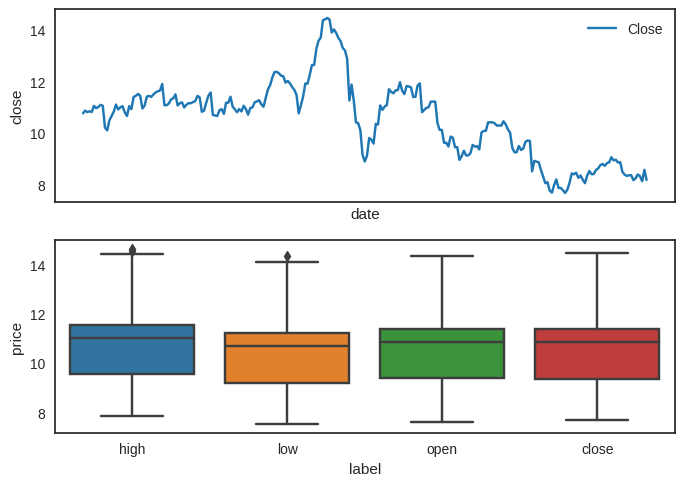

In [10]:
# reset the index to use it as x-axis data
stock.reset_index(inplace=True)
# reindex the dataframe
stock.index = [stock['date']]

style.use('seaborn-notebook')
style.use('seaborn-white')

# 2x1 plot
stock_fig = plt.figure()
stock_fig1 = stock_fig.add_subplot(211) # 2x1, fig.1
stock_fig2 = stock_fig.add_subplot(212) # 2x1, fig.2

# line plot for close
sns.lineplot(data=stock, x='date', y='close', label='Close', ax=stock_fig1)
# remove ticks and labels 
stock_fig1.tick_params(labelbottom=False, bottom=False)

# box plot for open, close, high, low
stock_prices = pd.DataFrame({'price': stock['high'], 'label': 'high'})
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['low'], 'label': 'low'})], sort=False)
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['open'], 'label': 'open'})], sort=False)
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['close'], 'label': 'close'})], sort=False)
sns.boxplot(x="label", y="price", data=stock_prices)

## Compute Features

Use default indicators from `stockstats` library.

In [11]:
stock  = sdf.retype(data)
# sort by date ascending 
stock.sort_index(ascending=True, inplace=True)

In [12]:
stock.init_all()

Some data cleaning

In [13]:
# find nan / inf rows
stock_nan_rows=stock[stock.isna().any(axis=1)]
stock_inf_rows=stock[(stock==np.inf).any(axis=1)]
# remove nan/inf rows
df = pd.concat([stock_nan_rows, stock_inf_rows], axis=1)
stock.drop(df.index,inplace=True)

### Some aux functions

`identify_partition` adds the column `partition` to the dataframe and marks the partions as follows:

* Partition $0$: train, random window sampling
* Partition $1$: train, consecutive window sampling
* Partition $2$: eval, consecutive window sampling, unless $\kappa_{random} = -1$, then it is random sampling, too.

In [14]:
def partition_edges():
    # create a local version of kappa_rando
    l_kappa_random = kappa_random
    
    if kappa_random == -1: # compare with global var
        l_kappa_random = kappa # define local var
    
    part_0_start = 0
    part_0_end = math.floor(len(stock)*(l_kappa_random)) 
    
    part_1_start = part_0_end
    part_1_end = part_1_start + math.floor(len(stock)*(kappa-l_kappa_random))
    
    part_2_start = part_1_end
    part_2_end = len(stock)
    
    part_start = [part_0_start, part_1_start, part_2_start]
    part_end = [part_0_end, part_1_end, part_2_end]

    part_no = [i for i in range(0,3)]
    return zip(part_start, part_end, part_no)

def identify_partition():
    assert k <= len(stock)
    # setup stock dataframe
    stock.sort_index(ascending=True, inplace=True)
    stock['partition'] = 0
    
    for s, e, p in partition_edges():
        stock.loc[stock[s:e].index, 'partition'] = p

`rand_window_idx` computes a list of $k$ random integers to use as window start indices. The function respects the the window length and the return horizon. As a consequence, the start indices can be further used to extract features without going out of bound of the stock dataframe.

In [15]:
def rand_window_idx(k, win_len, ret_horizon, stock_start=0, stock_end=len(stock)):
    assert win_len+ret_horizon < stock_end
    assert k>=0
    
    min_idx = stock_start
    max_idx = stock_end - (win_len + ret_horizon) - 1

    # return k random window start indices 
    return [random.randint(min_idx, max_idx) for i in range(k)]   

The function `stock_feature` selects a window of consecutive stock prices and computes a feature vector from it consisting of

* a series of stock prices
* window length value `win_len`
* all chart indicators at the last day of the window
* the return as ratio when we buy the stock at the window's last day and sell it `ret_horizon` days afterwards
* `ret_horizon` value

In [16]:
def stock_feature(win_start_idx, win_len, ret_horizon, stock=stock, price='close'):
    
    def stock_return():
        win_end_idx = win_start_idx + win_len
        ret_idx = win_end_idx + ret_horizon
        buy_price = stock.iloc[ret_idx-1][price]
        sell_price = stock.iloc[win_end_idx-1][price]
        ret_price = sell_price - buy_price
        ret = ret_price / buy_price 
        return ret
    
    def stock_return_greater_x(stock_ret, x):
        return True if stock_ret > x else False 
    
    def feature_retgtx(stock_ret):
        classification_target_vars = ['retgt'+str(x) for x in classification_targets]
        classification_target_vals = [stock_return_greater_x(stock_ret, x/100) for x in classification_targets]
        retgtx = pd.DataFrame(data=[classification_target_vals], columns=classification_target_vars, index=None)
        return retgtx
        
    win_end_idx = win_start_idx+win_len
    price_series = stock.iloc[win_start_idx:win_end_idx][price]    
    c_ind = stock.iloc[[win_end_idx-1]] # dataframe row at last day in window
    # remove the columns from the input data file, chart indicators remain
    # colnames defined when input csv file is loaded  
    drop_colnames = [colname for colname in colnames if colname != 'date']
    c_ind = c_ind.drop(columns=drop_colnames)
    
    # build feature vector from chart indicator dataframe
    feature = c_ind
    feature['price'] = " ".join(str(p) for p in price_series) 
    feature['win_len'] = win_len
    feature['return'] = stock_ret = stock_return()
    feature['ret_horizon'] = ret_horizon
    retgtx = feature_retgtx(stock_ret)
    retgtx['date'] = feature.index[0]
    retgtx.reset_index()
    retgtx = retgtx.set_index('date')
    feature = pd.concat([feature,retgtx], axis=1)
    
    return feature # feature vector is a dataframe

### Build the feature vector list

At first, identify which dates correspond to which partition according to the $\kappa$ and $\kappa_{random}$ parameter. Then draw samples from the partitions and compile the list of feature vectors. 

In [17]:
identify_partition()

For $m$ different window lengths and $m$ different return horizons, we select $k$ windows from the stock data. From each window, we compute the stock feature vector. The final feature set contains  $m * m * k$ feature vectors. The data structure is a list of dataframes each containing a feature vector.

In [18]:
# samples features 
def sample_features_from_partition(part_no, start_part, end_part, sample_feature=None):
    
    # create a local version of kappa_rando
    l_kappa_random = kappa_random
    if kappa_random == -1: # compare with global var
        l_kappa_random = kappa # define local var
    
    # number of samples per partition in relation to partition size
    if part_no == 0: # train, random window sampling 
        kp = math.floor(k * l_kappa_random)
    elif part_no == 1: # train, consecutive window sampling
        kp = math.floor(k * round((kappa - l_kappa_random),1))
    elif part_no == 2: # eval, consecutive window sampling
        kp = math.floor(k * round((1 - kappa),1))

    for j in h:
        for i in w:
            if part_no == 0: # train, random window sampling
                win_start = rand_window_idx(kp, i, j, stock_start=start_part, stock_end=min(end_part+j, len(stock)))
            elif part_no == 1: # train, consecutive window sampling
                start_range = max(end_part-kp-i+1,0) # dec i and inc 1 to stay in partition at end_window
                end_range = max(end_part-i+1, start_range)
                win_start = [r for r in range(start_range,end_range)]
            elif part_no == 2: # eval, consecutive window sampling
                start_range = max(start_part-i+1,0) # dec i and inc 1 to stay in partition at end_window
                end_range = max(start_part+kp-i+1, start_range)
                win_start = [r for r in range(start_range,end_range)]
                if kappa_random == -1: # eval, random window sampling
                    start_range = max(start_part-i+1, 0) # dec i and inc 1 to stay in partition at end_window
                    win_start = rand_window_idx(kp, i, j, stock_start=start_range)
            # extract feature vectors from stock_features
            for win_start_idx in win_start:
                sample_feature.append(stock_feature(win_start_idx, i, j))


In [19]:
# go through all partitions and perform sampling
# store result in the feature_set list
feature_set = list()

for s,e,p in partition_edges():
    sample_features_from_partition(p, s, e, sample_feature=feature_set)

# final set has a number of vectors from all parameter combinations
assert k*m*m == len(feature_set)

## Store Features in `.parquet` File

Output file names are values in variables `train_data_file` and `eval_data_file`.

In [20]:
# compile list with training vecs, write to train_csv_file
train_set_list = [f for f in feature_set if f.iloc[0]['partition'] == 0 or f.iloc[0]['partition'] == 1]
train_set_df = pd.concat(train_set_list)
train_set = train_set_df.copy() # copy defragments dataframe
#train_set.to_csv(path_or_buf=train_csv_file, mode='w', header=True, sep=',', na_rep='N/A', index=True, doublequote=True, escapechar=None, decimal='.', )
train_set.to_parquet(path=train_data_file, index=True)

In [21]:
# compile list with eval(test) vecs, write to eval_csv_file
eval_set_list = [f for f in feature_set if f.iloc[0]['partition'] == 2]
eval_set_df = pd.concat(eval_set_list)
eval_set = eval_set_df.copy() # copy defragments dataframe
#eval_set.to_csv(path_or_buf=eval_csv_file, mode='w', header=True, sep=',', na_rep='N/A', index=True, doublequote=True, escapechar=None, decimal='.', )
eval_set.to_parquet(path=eval_data_file, index=True)

## Test `.parquet` files

In [22]:
# read parquet file and compile columns names as string
# compare with data_sets
files = [train_data_file, eval_data_file]
data_sets = [train_set, eval_set]
part = [kappa, 1-kappa]

for f,d,p in zip(files, data_sets, part):
    df = pd.read_parquet(f)
    columns_str = ''.join(df.columns)
    header_str = ''.join(d.columns)
    assert header_str == columns_str # compare attributes
    assert len(d) == len(df) # compare number of rows: data_set and file
    assert math.floor(k*m*m*p) == len(df) # # compare number of rows with partition

## Create YAML file for ludwig

This is left over work. See `/YASMaPE/src/ludwig/setupyaml.sk` to setup initial ludwig config files. 

In [23]:
f = feature_set[0]
input_feature_attributes = [n for n in f.columns.tolist() if n not in ['price', 'return', 'ret_horizon', 'partition']]

for n in input_feature_attributes :
    s = ' ' * 4
    s += '-\n'
    s += ' ' * 8
    s += 'name: ' + n + '\n' 
    s += ' ' * 8
    s += 'type: number'
    s += '\n'
    #print(s)